In [58]:
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
import optuna

warnings.filterwarnings('ignore')

In [59]:


cols = ['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
        'compactness_mean', 'concavity_mean']
df = pd.read_csv('Cancer_Data.csv', usecols=cols)

df['diagnosis'][df.diagnosis == 'M'] = 0
df['diagnosis'][df.diagnosis == 'B'] = 1
df['diagnosis'] = pd.to_numeric(df['diagnosis'], errors='coerce')

X = df.drop(['diagnosis'], axis=1)

y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [60]:
class KNN:
    def __init__(self, k, metric='cosine', weights=None, kernel='uniform', kernel_param=None, use_parzen_window=False,
                 window_width=None):
        self.k = k
        self.metric = metric
        self.weights = weights
        self.kernel = kernel
        self.kernel_param = kernel_param
        self.use_parzen_window = use_parzen_window
        self.window_width = window_width

    def fit(self, X_train, y_train):
        self.X_train = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
        self.y_train = y_train.values if isinstance(y_train, pd.Series) else y_train

    def cosine_similarity(self, x1, x2):
        dot_product = np.dot(x1, x2)
        norm_x1 = np.linalg.norm(x1)
        norm_x2 = np.linalg.norm(x2)
        return dot_product / (norm_x1 * norm_x2)

    def manhattan_distance(self, x1, x2):
        return np.sum(np.abs(x1 - x2))

    def euclidean_distance(self, x1, x2):
        return np.linalg.norm(x1 - x2)

    def calculate_distance(self, x1, x2):
        if self.metric == 'cosine':
            return 1 - self.cosine_similarity(x1, x2)
        elif self.metric == 'manhattan':
            return self.manhattan_distance(x1, x2)
        elif self.metric == 'euclidean':
            return self.euclidean_distance(x1, x2)
        else:
            raise ValueError("Invalid metric. Please choose 'cosine', 'manhattan', or 'euclidean'.")

    def apply_weights(self, distances):
        if self.weights is None:
            return distances
        return np.multiply(distances, self.weights)

    def apply_kernel(self, distances):
        if self.kernel == 'uniform':
            if self.kernel_param is None:
                return distances
            else:
                return np.where(distances <= self.kernel_param, 1, 0)
        elif self.kernel == 'gaussian':
            if self.kernel_param is None:
                raise ValueError("Gaussian kernel requires kernel parameter (bandwidth).")
            else:
                return np.exp(-0.5 * (distances / self.kernel_param) ** 2)
        elif self.kernel == 'triangular':
            if self.kernel_param is None:
                raise ValueError("Triangular kernel requires kernel parameter (half-width).")
            else:
                return np.maximum(0, 1 - np.abs(distances) / self.kernel_param)
        else:
            raise ValueError("Invalid kernel. Please choose 'uniform', 'gaussian', or 'triangular'.")

    def parzen_window(self, distances):
        if self.window_width is None:
            raise ValueError("Parzen window requires window width parameter.")
        weights = np.zeros(len(distances))
        for i, dist in enumerate(distances):
            if dist <= self.window_width:
                weights[i] = 1
        return weights

    def predict(self, X_test):
        X_test = X_test.values if isinstance(X_test, pd.DataFrame) else X_test
        y_pred = []
        for i in range(len(X_test)):
            distances = []
            for j in range(len(self.X_train)):
                dist = self.calculate_distance(X_test[i], self.X_train[j])
                distances.append((self.y_train[j], dist))
            distances = self.apply_weights(np.array([x[1] for x in distances]))
            if self.use_parzen_window:
                distances = self.parzen_window(distances)
            else:
                distances = self.apply_kernel(distances)
            distances_with_labels = [(self.y_train[i], dist) for i, dist in enumerate(distances)]
            distances_with_labels.sort(key=lambda x: x[1])
            k_nearest = distances_with_labels[:self.k]
            k_nearest_labels = [label for label, _ in k_nearest]
            most_common = Counter(k_nearest_labels).most_common(1)
            y_pred.append(most_common[0][0])
        return y_pred


In [61]:
knn = KNN(k=9)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy = sum(y_pred == y_test) / len(y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8888888888888888


In [62]:
def objective(trial):

    k = trial.suggest_int('k', 1, 15)
    metric = trial.suggest_categorical('metric', ['cosine', 'manhattan', 'euclidean'])
    use_parzen_window = trial.suggest_categorical('use_parzen_window', [True, False])
    if use_parzen_window:
        window_width = trial.suggest_uniform('window_width', 0.1, 1.0)
    else:
        window_width = None
    kernel = trial.suggest_categorical('kernel', ['uniform', 'gaussian', 'triangular'])
    if kernel == 'gaussian':
        kernel_param = trial.suggest_uniform('kernel_param', 0.1, 1.0)
    elif kernel == 'triangular':
        kernel_param = trial.suggest_uniform('kernel_param', 0.1, 1.0)
    else:
        kernel_param = None


    knn = KNN(k=k, metric=metric, kernel=kernel, kernel_param=kernel_param,
              use_parzen_window=use_parzen_window, window_width=window_width)

    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=150)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-03-19 17:56:24,503] A new study created in memory with name: no-name-7a9618b9-a875-47f2-82af-d57f16cfc24a
[I 2024-03-19 17:56:24,659] Trial 0 finished with value: 0.631578947368421 and parameters: {'k': 1, 'metric': 'manhattan', 'use_parzen_window': True, 'window_width': 0.37714741709225885, 'kernel': 'gaussian', 'kernel_param': 0.13662692995169629}. Best is trial 0 with value: 0.631578947368421.
[I 2024-03-19 17:56:24,807] Trial 1 finished with value: 0.631578947368421 and parameters: {'k': 13, 'metric': 'euclidean', 'use_parzen_window': False, 'kernel': 'triangular', 'kernel_param': 0.10734623552552586}. Best is trial 0 with value: 0.631578947368421.
[I 2024-03-19 17:56:24,946] Trial 2 finished with value: 0.631578947368421 and parameters: {'k': 10, 'metric': 'euclidean', 'use_parzen_window': False, 'kernel': 'gaussian', 'kernel_param': 0.8204745311528706}. Best is trial 0 with value: 0.631578947368421.
[I 2024-03-19 17:56:25,106] Trial 3 finished with value: 0.63157894736842

Best hyperparameters: {'k': 12, 'metric': 'manhattan', 'use_parzen_window': False, 'kernel': 'uniform'}


In [63]:
def objective(trial):

    n_neighbors = trial.suggest_int('n_neighbors', 1, 15)
    metric = trial.suggest_categorical('metric', ['cosine', 'euclidean', 'manhattan'])

    knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)

    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=150)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-03-19 17:56:46,504] A new study created in memory with name: no-name-77abbac1-7799-48be-83e2-5daf1032a695
[I 2024-03-19 17:56:46,509] Trial 0 finished with value: 0.8947368421052632 and parameters: {'n_neighbors': 14, 'metric': 'manhattan'}. Best is trial 0 with value: 0.8947368421052632.
[I 2024-03-19 17:56:46,513] Trial 1 finished with value: 0.8654970760233918 and parameters: {'n_neighbors': 1, 'metric': 'euclidean'}. Best is trial 0 with value: 0.8947368421052632.
[I 2024-03-19 17:56:46,517] Trial 2 finished with value: 0.8771929824561403 and parameters: {'n_neighbors': 10, 'metric': 'euclidean'}. Best is trial 0 with value: 0.8947368421052632.
[I 2024-03-19 17:56:46,531] Trial 3 finished with value: 0.8888888888888888 and parameters: {'n_neighbors': 13, 'metric': 'cosine'}. Best is trial 0 with value: 0.8947368421052632.
[I 2024-03-19 17:56:46,557] Trial 4 finished with value: 0.8947368421052632 and parameters: {'n_neighbors': 12, 'metric': 'cosine'}. Best is trial 0 with 

Best hyperparameters: {'n_neighbors': 15, 'metric': 'manhattan'}


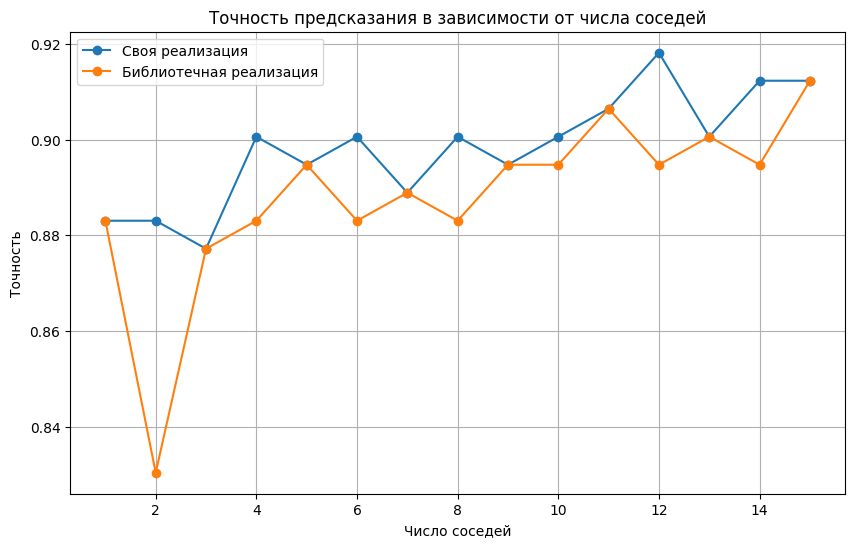

In [64]:
import matplotlib.pyplot as plt

def plot_accuracy_vs_k(k_values, accuracy_values, label):
    plt.plot(k_values, accuracy_values, marker='o', linestyle='-', label=label)

# Define a range of values for k
k_values = list(range(1,16))
plt.figure(figsize=(10, 6))
plt.title('Точность предсказания в зависимости от числа соседей')
plt.xlabel('Число соседей')
plt.ylabel('Точность')
plt.grid(True)

accuracy_values = []
for k in k_values:
    knn = KNN(k=k, metric='manhattan')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_values.append(accuracy)
plot_accuracy_vs_k(k_values, accuracy_values, 'Своя реализация')


accuracy_values = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_values.append(accuracy)
plot_accuracy_vs_k(k_values, accuracy_values, 'Библиотечная реализация')

plt.legend(loc="upper left")
plt.show()